In [1]:
# The program is modified from the original program provided by the user @tejasri19, please see https://github.com/tejasri19/EuroSAT_data_analysis/blob/main/All_bands/EuroSAT_Resnet.ipynb for original code
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install torchsummary
from torchsummary import summary
from transformers import ViTModel, ViTConfig, ViTForImageClassification

# set the path to the directory containing the npy files
data_dir = '.../yourNumpyDataset'

# set the path to save the trained model
model_path = '.../outputPath'

if not os.path.exists(model_path):
    os.makedirs(model_path)
# load the X and y data for each class
X = []
y = []
for i in range(10):
    X_i = np.load(f'{data_dir}/X{i}.npy')
    y_i = np.load(f'{data_dir}/y{i}.npy')
    X.append(X_i)
    y.append(y_i)

# concatenate the X and y data for all classes
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install einops
import einops
print(X.shape)


X = einops.rearrange(X, 'b h w c -> b c h w')
              
print(X.shape)

print(X[0].shape)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.3 MB/s eta 0:00:00
(27000, 64, 64, 1)
(27000, 1, 64, 64)
(1, 64, 64)


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit


# split the data into training and testing sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# split the data
for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [4]:
# Free up the memory for better utilization
del X
del y

In [5]:

# define a custom dataset class for the EuroSAT multispectral data
class EuroSATDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# create data loaders for the training and testing sets
train_dataset = EuroSATDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = EuroSATDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# set the device to use for training and testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
print(len(train_loader))

675


In [7]:
print(len(test_loader))

169


In [8]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [9]:
# Define the ResNet-50 model
model = models.resnet50(pretrained=False)
num_classes = 10
model.fc = nn.Linear(2048, num_classes)

# Modify the first convolution layer to accept 5-channel input
# for multi-spectral training, please change "1" to value of channels used
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model and loss function to the device
model.to(device)
criterion.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


CrossEntropyLoss()

In [10]:
import torchsummary

# Print the model summary
# for multi-spectral training, please change "1" to value of channels used
torchsummary.summary(model.to(device), input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)
    
    model.train()
    running_loss=0
    correct=0
    total=0

    for images, labels in tqdm(train_loader):
        
        images = images.float().cuda()
        labels = labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))
        
        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)
        
        
       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
    #Replaces pow(2.0) with abs() for L1 regularization
    
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm
    
        
        running_loss += loss.item()
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
  
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    

In [12]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            labels = labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)
            
            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()
            
            
           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
    

In [13]:
from tqdm import tqdm

In [14]:
import time
epochs = 30

# Start the timer

start_time = time.time()
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))


Epoch : 1


100%|██████████| 675/675 [00:37<00:00, 17.90it/s]


Train Loss: 1.613 | Accuracy: 43.454


100%|██████████| 169/169 [00:01<00:00, 87.20it/s]


Test Loss: 1.743 | Accuracy: 41.981
Epoch : 2


100%|██████████| 675/675 [00:36<00:00, 18.44it/s]


Train Loss: 1.264 | Accuracy: 55.417


100%|██████████| 169/169 [00:01<00:00, 89.14it/s]


Test Loss: 1.487 | Accuracy: 41.130
Epoch : 3


100%|██████████| 675/675 [00:36<00:00, 18.45it/s]


Train Loss: 1.086 | Accuracy: 60.111


100%|██████████| 169/169 [00:01<00:00, 89.52it/s]


Test Loss: 1.140 | Accuracy: 60.241
Epoch : 4


100%|██████████| 675/675 [00:36<00:00, 18.45it/s]


Train Loss: 0.973 | Accuracy: 64.736


100%|██████████| 169/169 [00:01<00:00, 88.39it/s]


Test Loss: 0.996 | Accuracy: 69.315
Epoch : 5


100%|██████████| 675/675 [00:36<00:00, 18.46it/s]


Train Loss: 0.936 | Accuracy: 66.023


100%|██████████| 169/169 [00:01<00:00, 89.90it/s]


Test Loss: 1.042 | Accuracy: 62.796
Epoch : 6


100%|██████████| 675/675 [00:36<00:00, 18.48it/s]


Train Loss: 0.895 | Accuracy: 67.903


100%|██████████| 169/169 [00:01<00:00, 87.73it/s]


Test Loss: 1.531 | Accuracy: 55.315
Epoch : 7


100%|██████████| 675/675 [00:36<00:00, 18.42it/s]


Train Loss: 1.092 | Accuracy: 61.208


100%|██████████| 169/169 [00:01<00:00, 90.08it/s]


Test Loss: 0.981 | Accuracy: 64.630
Epoch : 8


100%|██████████| 675/675 [00:36<00:00, 18.44it/s]


Train Loss: 0.910 | Accuracy: 67.074


100%|██████████| 169/169 [00:01<00:00, 88.27it/s]


Test Loss: 2.121 | Accuracy: 47.333
Epoch : 9


100%|██████████| 675/675 [00:36<00:00, 18.48it/s]


Train Loss: 0.750 | Accuracy: 72.495


100%|██████████| 169/169 [00:01<00:00, 90.06it/s]


Test Loss: 1.212 | Accuracy: 61.407
Epoch : 10


100%|██████████| 675/675 [00:36<00:00, 18.45it/s]


Train Loss: 0.752 | Accuracy: 72.421


100%|██████████| 169/169 [00:01<00:00, 88.21it/s]


Test Loss: 0.857 | Accuracy: 71.296
Epoch : 11


100%|██████████| 675/675 [00:36<00:00, 18.46it/s]


Train Loss: 0.669 | Accuracy: 75.375


100%|██████████| 169/169 [00:01<00:00, 87.96it/s]


Test Loss: 1.908 | Accuracy: 51.685
Epoch : 12


100%|██████████| 675/675 [00:36<00:00, 18.44it/s]


Train Loss: 0.620 | Accuracy: 77.019


100%|██████████| 169/169 [00:01<00:00, 89.12it/s]


Test Loss: 1.656 | Accuracy: 61.722
Epoch : 13


100%|██████████| 675/675 [00:36<00:00, 18.45it/s]


Train Loss: 0.577 | Accuracy: 78.847


100%|██████████| 169/169 [00:01<00:00, 88.16it/s]


Test Loss: 0.919 | Accuracy: 72.019
Epoch : 14


100%|██████████| 675/675 [00:36<00:00, 18.46it/s]


Train Loss: 0.531 | Accuracy: 80.394


100%|██████████| 169/169 [00:01<00:00, 89.83it/s]


Test Loss: 0.642 | Accuracy: 77.352
Epoch : 15


100%|██████████| 675/675 [00:36<00:00, 18.45it/s]


Train Loss: 0.515 | Accuracy: 81.051


100%|██████████| 169/169 [00:01<00:00, 88.78it/s]


Test Loss: 3.062 | Accuracy: 59.333
Epoch : 16


100%|██████████| 675/675 [00:36<00:00, 18.45it/s]


Train Loss: 0.437 | Accuracy: 84.130


100%|██████████| 169/169 [00:01<00:00, 89.53it/s]


Test Loss: 1.429 | Accuracy: 63.222
Epoch : 17


100%|██████████| 675/675 [00:36<00:00, 18.48it/s]


Train Loss: 0.393 | Accuracy: 85.472


100%|██████████| 169/169 [00:01<00:00, 88.45it/s]


Test Loss: 0.742 | Accuracy: 75.981
Epoch : 18


100%|██████████| 675/675 [00:36<00:00, 18.45it/s]


Train Loss: 0.345 | Accuracy: 87.495


100%|██████████| 169/169 [00:01<00:00, 89.84it/s]


Test Loss: 1.747 | Accuracy: 69.907
Epoch : 19


100%|██████████| 675/675 [00:36<00:00, 18.43it/s]


Train Loss: 0.334 | Accuracy: 87.806


100%|██████████| 169/169 [00:01<00:00, 84.80it/s]


Test Loss: 1.509 | Accuracy: 70.148
Epoch : 20


100%|██████████| 675/675 [00:36<00:00, 18.42it/s]


Train Loss: 0.275 | Accuracy: 89.898


100%|██████████| 169/169 [00:01<00:00, 90.07it/s]


Test Loss: 3.472 | Accuracy: 59.667
Epoch : 21


100%|██████████| 675/675 [00:36<00:00, 18.45it/s]


Train Loss: 0.284 | Accuracy: 89.875


100%|██████████| 169/169 [00:01<00:00, 88.68it/s]


Test Loss: 1.038 | Accuracy: 71.778
Epoch : 22


100%|██████████| 675/675 [00:36<00:00, 18.41it/s]


Train Loss: 0.228 | Accuracy: 91.787


100%|██████████| 169/169 [00:01<00:00, 89.78it/s]


Test Loss: 1.103 | Accuracy: 70.852
Epoch : 23


100%|██████████| 675/675 [00:36<00:00, 18.42it/s]


Train Loss: 0.220 | Accuracy: 92.148


100%|██████████| 169/169 [00:01<00:00, 89.42it/s]


Test Loss: 1.048 | Accuracy: 72.056
Epoch : 24


100%|██████████| 675/675 [00:36<00:00, 18.39it/s]


Train Loss: 0.185 | Accuracy: 93.366


100%|██████████| 169/169 [00:01<00:00, 88.80it/s]


Test Loss: 1.120 | Accuracy: 71.259
Epoch : 25


100%|██████████| 675/675 [00:36<00:00, 18.44it/s]


Train Loss: 0.166 | Accuracy: 94.199


100%|██████████| 169/169 [00:01<00:00, 89.25it/s]


Test Loss: 5.408 | Accuracy: 56.426
Epoch : 26


100%|██████████| 675/675 [00:36<00:00, 18.46it/s]


Train Loss: 0.329 | Accuracy: 88.884


100%|██████████| 169/169 [00:01<00:00, 89.66it/s]


Test Loss: 1.604 | Accuracy: 66.444
Epoch : 27


100%|██████████| 675/675 [00:36<00:00, 18.44it/s]


Train Loss: 0.159 | Accuracy: 94.329


100%|██████████| 169/169 [00:01<00:00, 89.56it/s]


Test Loss: 1.308 | Accuracy: 68.352
Epoch : 28


100%|██████████| 675/675 [00:36<00:00, 18.36it/s]


Train Loss: 0.129 | Accuracy: 95.509


100%|██████████| 169/169 [00:01<00:00, 88.39it/s]


Test Loss: 1.733 | Accuracy: 65.778
Epoch : 29


100%|██████████| 675/675 [00:36<00:00, 18.40it/s]


Train Loss: 0.163 | Accuracy: 94.389


100%|██████████| 169/169 [00:01<00:00, 88.72it/s]


Test Loss: 1.178 | Accuracy: 75.056
Epoch : 30


100%|██████████| 675/675 [00:36<00:00, 18.36it/s]


Train Loss: 0.173 | Accuracy: 93.958


100%|██████████| 169/169 [00:01<00:00, 87.47it/s]

Test Loss: 1.059 | Accuracy: 74.981
Training time: 1156.81 seconds


In [15]:
import matplotlib.pyplot as plt


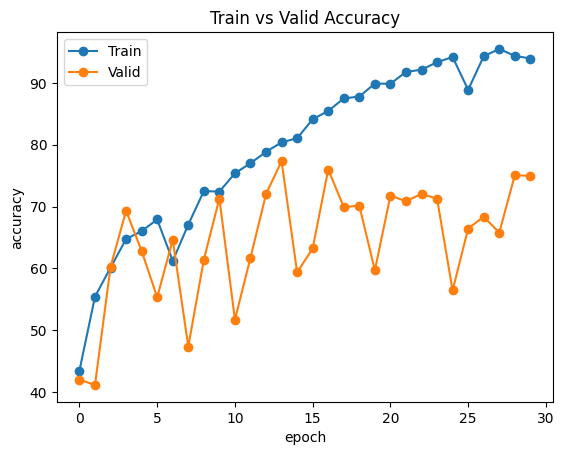

In [16]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

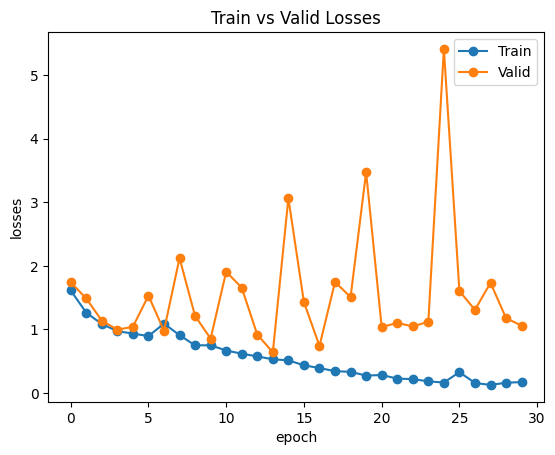

In [17]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [18]:
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score

# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for (X_val, y_val) in tqdm(test_loader):
        X_val = X_val.float().cuda()
        y_val = y_val.float().cuda()
        #X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)
        
        output = model(X_val)
        #print(output.shape)
        
        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)
    
    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)

100%|██████████| 169/169 [00:01<00:00, 95.76it/s]


Precision:  0.7499975531864278
Recall:  0.7391166666666666
Confusion matrix:
 [[531   0  15  13   4   5  26   1   0   5]
 [  8 505  21   0   0  40   0   1   1  24]
 [ 50   4 395   5  17  28  60  25   9   7]
 [ 27   0  25 288  39  21  26  27  47   0]
 [  2   0  10  12 357   1   6 112   0   0]
 [ 55   7  23   9   0 259  15   1  20  11]
 [ 83   1  98   7  14  20 270   5   2   0]
 [  0   1  27   6  39   0   6 520   1   0]
 [ 10   5  11  42  12  38   4   9 366   3]
 [ 28   1   1   1   0   4   0   0   7 558]]
Report:
               precision    recall  f1-score   support

         0.0       0.67      0.89      0.76       600
         1.0       0.96      0.84      0.90       600
         2.0       0.63      0.66      0.64       600
         3.0       0.75      0.58      0.65       500
         4.0       0.74      0.71      0.73       500
         5.0       0.62      0.65      0.63       400
         6.0       0.65      0.54      0.59       500
         7.0       0.74      0.87      0.80      